In [1]:
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from missforest import MissForest
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor, XGBClassifier
import shap
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor, LazyClassifier
from scipy.stats import randint, uniform, zscore, stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error, accuracy_score, classification_report
from sklearn.preprocessing import TargetEncoder
from sklearn import linear_model
from sklearn.linear_model import Lasso, LogisticRegression
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
import joblib

In [2]:
df = pd.read_csv('https://storage.googleapis.com/breathecode/project-files/bank-marketing-campaign-data.csv',sep=';',quotechar='"')
mapeo_columns = {'default':'has_cred','duration':'duration_secs','campaign':'touch_points','pdays':'interv_contact','previous':'prev_touchpt','poutcome':'past_result'}
df = df.rename(columns=mapeo_columns)
pd.set_option('display.max_columns', None)
df

,age,job,marital,education,has_cred,housing,loan,contact,month,day_of_week,duration_secs,touch_points,interv_contact,prev_touchpt,past_result,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,yes


In [3]:
df.shape

(41188, 21)

In [4]:
unicos = df.nunique()
print(unicos)

age                 78
job                 12
marital              4
education            8
has_cred             3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration_secs     1544
touch_points        42
interv_contact      27
prev_touchpt         8
past_result          3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64


In [5]:
df.duplicated().sum()

np.int64(12)

In [6]:
#revision filas duplicadas
filas_dup = df[df.duplicated(keep=False)]


In [7]:
#eliminar filas duplicadas
df.drop_duplicates(inplace=True)

In [8]:
#identificar columnas duplicadas
df.T.duplicated().sum()
df.T.duplicated(keep=False)

age               False
job               False
marital           False
education         False
has_cred          False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration_secs     False
touch_points      False
interv_contact    False
prev_touchpt      False
past_result       False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

In [9]:
#Encontrar otros valores faltantes 

df_categories = df.select_dtypes(include=['object'])
# sacamos la cantidad de unknown por columna
unknown_counts = df_categories.apply(lambda col: (col == "unknown").sum())
# sacamos el porcentaje de unknown
unknown_percentage = df_categories.apply(lambda col: (col == "unknown").mean()*100)
# creamos un DF con esta info
df_result=pd.DataFrame({'unknown_counts':unknown_counts,'unknown_porcentaje':unknown_percentage}).sort_values(by='unknown_counts',ascending=False)
df_result

,unknown_counts,unknown_porcentaje
has_cred,8596,20.88
education,1730,4.20
housing,990,2.40
loan,990,2.40
job,330,0.80
marital,80,0.19
contact,0,0.00
month,0,0.00
day_of_week,0,0.00
past_result,0,0.00


In [10]:
df.shape

(41176, 21)

In [11]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]
print(faltantes)

age              0.00
job              0.00
marital          0.00
education        0.00
has_cred         0.00
housing          0.00
loan             0.00
contact          0.00
month            0.00
day_of_week      0.00
duration_secs    0.00
touch_points     0.00
interv_contact   0.00
prev_touchpt     0.00
past_result      0.00
emp.var.rate     0.00
cons.price.idx   0.00
cons.conf.idx    0.00
euribor3m        0.00
nr.employed      0.00
y                0.00
dtype: float64


In [12]:
#identificar otros valores faltantes

cat_col = df.select_dtypes(include=['object']).columns

for col in cat_col: 
    print(df[col].value_counts())

job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64
education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64
has_cred
no         32577
unknown     8596
yes            3
Name: count, dtype: int64
housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64
loan
no         33938
yes         6248
unknown      990
Name: count, dtype: int64
contact
cellular     26135
telephone    15041
Name: count, dtype: i

In [13]:
#Transformar unknowns a NaNs
df_faltantes = df.replace(['unknown'],np.nan,inplace=True)
df


,age,job,marital,education,has_cred,housing,loan,contact,month,day_of_week,duration_secs,touch_points,interv_contact,prev_touchpt,past_result,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,yes


In [14]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

job          0.80
marital      0.19
education    4.20
has_cred    20.88
housing      2.40
loan         2.40
dtype: float64

<Axes: >

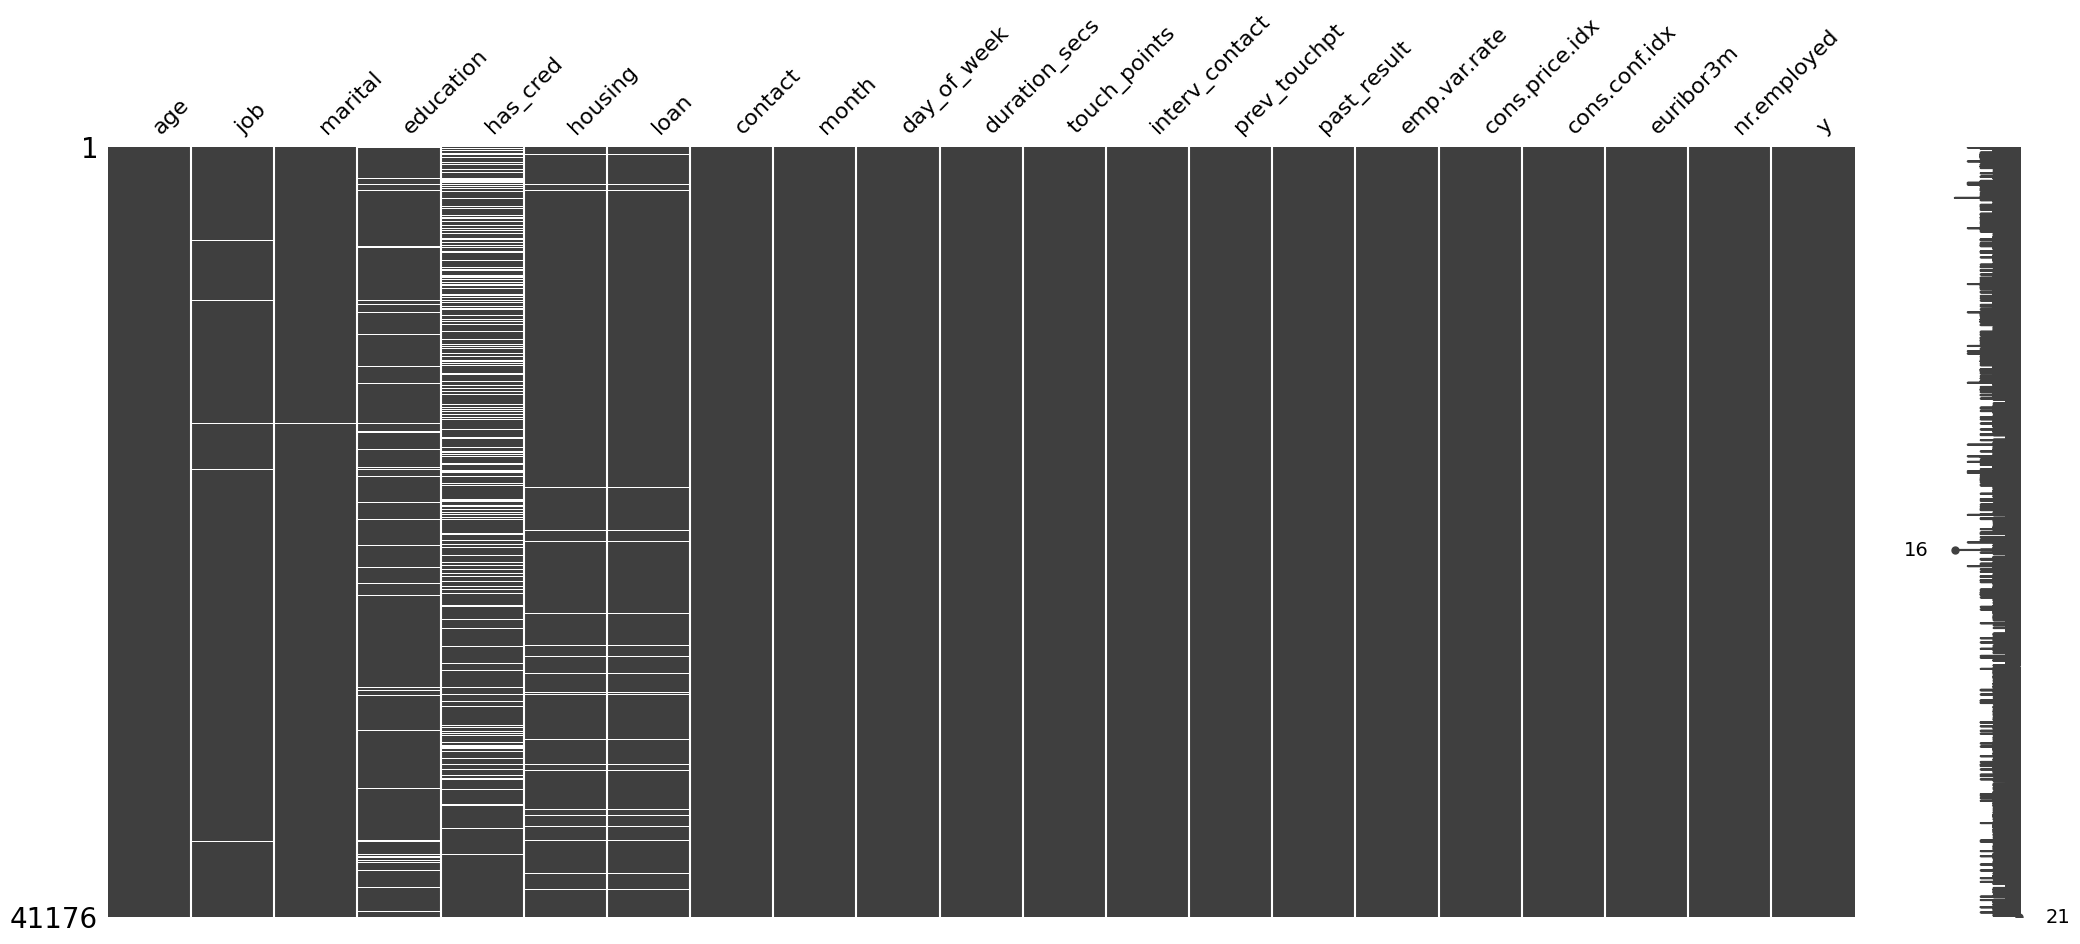

In [15]:
msno.matrix(df)

In [16]:
df['y'].unique()


array(['no', 'yes'], dtype=object)

In [17]:
df['y'] = df['y'].map({'no': 0, 'yes': 1})

In [18]:
df

,age,job,marital,education,has_cred,housing,loan,contact,month,day_of_week,duration_secs,touch_points,interv_contact,prev_touchpt,past_result,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.10,94.77,-50.80,1.03,4963.60,1


Train Test Split

In [19]:
X = df.drop('y',axis=1)
Y = df['y']

In [20]:
X_train,X_test,Y_train,Y_Test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32940 entries, 12348 to 15798
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32940 non-null  int64  
 1   job             32665 non-null  object 
 2   marital         32875 non-null  object 
 3   education       31548 non-null  object 
 4   has_cred        26110 non-null  object 
 5   housing         32151 non-null  object 
 6   loan            32151 non-null  object 
 7   contact         32940 non-null  object 
 8   month           32940 non-null  object 
 9   day_of_week     32940 non-null  object 
 10  duration_secs   32940 non-null  int64  
 11  touch_points    32940 non-null  int64  
 12  interv_contact  32940 non-null  int64  
 13  prev_touchpt    32940 non-null  int64  
 14  past_result     32940 non-null  object 
 15  emp.var.rate    32940 non-null  float64
 16  cons.price.idx  32940 non-null  float64
 17  cons.conf.idx   32940 non-null  

In [22]:
X_train.isna().sum()

age                  0
job                275
marital             65
education         1392
has_cred          6830
housing            789
loan               789
contact              0
month                0
day_of_week          0
duration_secs        0
touch_points         0
interv_contact       0
prev_touchpt         0
past_result          0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
dtype: int64

In [23]:
X_train.dtypes

age                 int64
job                object
marital            object
education          object
has_cred           object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration_secs       int64
touch_points        int64
interv_contact      int64
prev_touchpt        int64
past_result        object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

Imputar

In [24]:
cat_cols = ['job','marital','education','has_cred','housing','loan',
            'contact','month','day_of_week','past_result']

# Codificar X_train
X_train_enc = X_train.copy()
category_maps = {}

for col in cat_cols:
    s = X_train_enc[col].astype('category')
    category_maps[col] = s.cat.categories
    codes = s.cat.codes
    X_train_enc[col] = codes.replace(-1, np.nan).astype('float')

# Codificar X_test igual que train
X_test_enc = X_test.copy()

for col in cat_cols:
    s = X_test_enc[col].astype('category')
    s = s.cat.set_categories(category_maps[col])
    codes = s.cat.codes
    X_test_enc[col] = codes.replace(-1, np.nan).astype('float')

# Imputación con MissForest
imputer = MissForest(categorical=cat_cols)

X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train_enc),
    columns=X_train_enc.columns,
    index=X_train_enc.index
)

X_test_imp = pd.DataFrame(
    imputer.transform(X_test_enc),
    columns=X_test_enc.columns,
    index=X_test_enc.index
)

# OUTPUT FINAL por separado
print("X_train_imp listo:")
display(X_train_imp.head())

print("X_test_imp listo:")
display(X_test_imp.head())

100%|██████████| 5/5 [00:00<00:00, 16.88it/s]


X_train_imp listo:


,age,job,marital,education,has_cred,housing,loan,contact,month,day_of_week,duration_secs,touch_points,interv_contact,prev_touchpt,past_result,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
12348,29,2.00,1.00,1.00,0.00,1.00,1.00,1.00,3.00,0.00,286,3,999,0,1.00,1.40,93.92,-42.70,4.96,5228.10
8565,50,0.00,2.00,6.00,0.00,0.00,0.00,1.00,4.00,4.00,178,6,999,0,1.00,1.40,94.47,-41.80,4.86,5228.10
21424,29,0.00,2.00,6.00,0.00,0.00,0.00,0.00,1.00,3.00,103,4,999,0,1.00,1.40,93.44,-36.10,4.96,5228.10
3316,35,0.00,2.00,6.00,0.00,0.00,0.00,1.00,6.00,2.00,135,1,999,0,1.00,1.10,93.99,-36.40,4.86,5191.00
33246,40,1.00,2.00,3.00,0.00,0.00,0.00,0.00,6.00,3.00,418,1,999,0,1.00,-1.80,92.89,-46.20,1.29,5099.10


X_test_imp listo:


,age,job,marital,education,has_cred,housing,loan,contact,month,day_of_week,duration_secs,touch_points,interv_contact,prev_touchpt,past_result,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
36264,59,5.00,1.00,5.00,0.00,1.00,1.00,0.00,4.00,1.00,1460,1,999,0,1.00,-2.90,92.96,-40.80,1.27,5076.20
32672,34,1.00,1.00,2.00,0.00,0.00,0.00,0.00,6.00,1.00,248,1,999,1,0.00,-1.80,92.89,-46.20,1.30,5099.10
40872,32,9.00,1.00,5.00,0.00,1.00,0.00,0.00,8.00,4.00,275,2,999,0,1.00,-1.10,94.60,-49.50,0.96,4963.60
32907,53,0.00,1.00,3.00,0.00,1.00,1.00,0.00,6.00,1.00,186,2,999,1,0.00,-1.80,92.89,-46.20,1.30,5099.10
16464,24,7.00,2.00,2.00,0.00,1.00,0.00,1.00,3.00,4.00,184,1,999,0,1.00,1.40,93.92,-42.70,4.96,5228.10


Cod. Variables Categoricas

In [25]:
#Target encoder
cols = ['job','marital','housing','loan','month','day_of_week','past_result']

target_encoder = TargetEncoder(target_type='binary',smooth='auto',cv=5)
X_train_col_enc = target_encoder.fit_transform(X_train[cols],Y_train)
X_test_col_enc = target_encoder.transform(X_test[cols])

for idx,column in enumerate(cols):
        X_train[f'{column}_encoded'] = X_train_col_enc[:,idx]
        X_test[f'{column}_encoded'] = X_test_col_enc[:,idx]
        
X_train.drop(columns=cols,axis=1,inplace=True)
X_test.drop(columns=cols,axis=1,inplace=True)


In [26]:
X_train.head()

,age,education,has_cred,contact,duration_secs,touch_points,interv_contact,prev_touchpt,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_encoded,marital_encoded,housing_encoded,loan_encoded,month_encoded,day_of_week_encoded,past_result_encoded
12348,29,basic.6y,no,telephone,286,3,999,0,1.40,93.92,-42.70,4.96,5228.10,0.08,0.10,0.11,0.10,0.09,0.11,0.09
8565,50,university.degree,no,telephone,178,6,999,0,1.40,94.47,-41.80,4.86,5228.10,0.13,0.14,0.11,0.11,0.10,0.12,0.09
21424,29,university.degree,no,cellular,103,4,999,0,1.40,93.44,-36.10,4.96,5228.10,0.13,0.14,0.11,0.11,0.10,0.12,0.09
3316,35,university.degree,no,telephone,135,1,999,0,1.10,93.99,-36.40,4.86,5191.00,0.13,0.14,0.11,0.11,0.06,0.12,0.09
33246,40,high.school,NaN,cellular,418,1,999,0,-1.80,92.89,-46.20,1.29,5099.10,0.07,0.14,0.11,0.11,0.07,0.12,0.09


In [27]:
#ordinal encoder

education_type = [['unknown','illiterate','basic.4y','basic.6y','basic.9y','high.school','professional.course','university.degree']]

ordinal_encoder = OrdinalEncoder(categories=education_type,handle_unknown='use_encoded_value',unknown_value=-1)

X_train['education_type_encoded'] = ordinal_encoder.fit_transform(X_train[['education']])
X_test['education_type_encoded']= ordinal_encoder.transform(X_test[['education']])

X_train.drop('education',axis=1,inplace=True)
X_test.drop('education',axis=1,inplace=True)

In [28]:
X_train.head()

,age,has_cred,contact,duration_secs,touch_points,interv_contact,prev_touchpt,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_encoded,marital_encoded,housing_encoded,loan_encoded,month_encoded,day_of_week_encoded,past_result_encoded,education_type_encoded
12348,29,no,telephone,286,3,999,0,1.40,93.92,-42.70,4.96,5228.10,0.08,0.10,0.11,0.10,0.09,0.11,0.09,3.00
8565,50,no,telephone,178,6,999,0,1.40,94.47,-41.80,4.86,5228.10,0.13,0.14,0.11,0.11,0.10,0.12,0.09,7.00
21424,29,no,cellular,103,4,999,0,1.40,93.44,-36.10,4.96,5228.10,0.13,0.14,0.11,0.11,0.10,0.12,0.09,7.00
3316,35,no,telephone,135,1,999,0,1.10,93.99,-36.40,4.86,5191.00,0.13,0.14,0.11,0.11,0.06,0.12,0.09,7.00
33246,40,NaN,cellular,418,1,999,0,-1.80,92.89,-46.20,1.29,5099.10,0.07,0.14,0.11,0.11,0.07,0.12,0.09,5.00


In [29]:
#OneHot Encoder

encoder = OneHotEncoder(drop=None,sparse_output=False)

encoded_train = encoder.fit_transform(X_train[['has_cred']])
encoded_test = encoder.transform(X_test[['has_cred']])

new_cols = encoder.get_feature_names_out(['has_cred'])

X_train[new_cols] = encoded_train
X_test[new_cols] = encoded_test

X_train.drop('has_cred',axis=1,inplace=True)
X_test.drop('has_cred',axis=1,inplace=True)





In [30]:
X_train.head()

,age,contact,duration_secs,touch_points,interv_contact,prev_touchpt,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_encoded,marital_encoded,housing_encoded,loan_encoded,month_encoded,day_of_week_encoded,past_result_encoded,education_type_encoded,has_cred_no,has_cred_yes,has_cred_nan
12348,29,telephone,286,3,999,0,1.40,93.92,-42.70,4.96,5228.10,0.08,0.10,0.11,0.10,0.09,0.11,0.09,3.00,1.00,0.00,0.00
8565,50,telephone,178,6,999,0,1.40,94.47,-41.80,4.86,5228.10,0.13,0.14,0.11,0.11,0.10,0.12,0.09,7.00,1.00,0.00,0.00
21424,29,cellular,103,4,999,0,1.40,93.44,-36.10,4.96,5228.10,0.13,0.14,0.11,0.11,0.10,0.12,0.09,7.00,1.00,0.00,0.00
3316,35,telephone,135,1,999,0,1.10,93.99,-36.40,4.86,5191.00,0.13,0.14,0.11,0.11,0.06,0.12,0.09,7.00,1.00,0.00,0.00
33246,40,cellular,418,1,999,0,-1.80,92.89,-46.20,1.29,5099.10,0.07,0.14,0.11,0.11,0.07,0.12,0.09,5.00,0.00,0.00,1.00


In [31]:
#mapear columna contact

X_train['contact'] = X_train['contact'].map({'telephone': 0, 'cellular': 1})
X_test['contact']  = X_test['contact'].map({'telephone': 0, 'cellular': 1})



In [32]:
X_train.head()

,age,contact,duration_secs,touch_points,interv_contact,prev_touchpt,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_encoded,marital_encoded,housing_encoded,loan_encoded,month_encoded,day_of_week_encoded,past_result_encoded,education_type_encoded,has_cred_no,has_cred_yes,has_cred_nan
12348,29,0,286,3,999,0,1.40,93.92,-42.70,4.96,5228.10,0.08,0.10,0.11,0.10,0.09,0.11,0.09,3.00,1.00,0.00,0.00
8565,50,0,178,6,999,0,1.40,94.47,-41.80,4.86,5228.10,0.13,0.14,0.11,0.11,0.10,0.12,0.09,7.00,1.00,0.00,0.00
21424,29,1,103,4,999,0,1.40,93.44,-36.10,4.96,5228.10,0.13,0.14,0.11,0.11,0.10,0.12,0.09,7.00,1.00,0.00,0.00
3316,35,0,135,1,999,0,1.10,93.99,-36.40,4.86,5191.00,0.13,0.14,0.11,0.11,0.06,0.12,0.09,7.00,1.00,0.00,0.00
33246,40,1,418,1,999,0,-1.80,92.89,-46.20,1.29,5099.10,0.07,0.14,0.11,0.11,0.07,0.12,0.09,5.00,0.00,0.00,1.00


In [33]:
X_train.isna().mean()*100

age                      0.00
contact                  0.00
duration_secs            0.00
touch_points             0.00
interv_contact           0.00
prev_touchpt             0.00
emp.var.rate             0.00
cons.price.idx           0.00
cons.conf.idx            0.00
euribor3m                0.00
nr.employed              0.00
job_encoded              0.00
marital_encoded          0.00
housing_encoded          0.00
loan_encoded             0.00
month_encoded            0.00
day_of_week_encoded      0.00
past_result_encoded      0.00
education_type_encoded   0.00
has_cred_no              0.00
has_cred_yes             0.00
has_cred_nan             0.00
dtype: float64

Outliers

In [34]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32940.00,40.04,10.43,17.00,32.00,38.00,47.00,98.00
contact,32940.00,0.63,0.48,0.00,0.00,1.00,1.00,1.00
duration_secs,32940.00,256.97,258.11,0.00,102.00,178.00,318.25,4918.00
touch_points,32940.00,2.58,2.78,1.00,1.00,2.00,3.00,56.00
interv_contact,32940.00,962.37,187.16,0.00,999.00,999.00,999.00,999.00
prev_touchpt,32940.00,0.17,0.49,0.00,0.00,0.00,0.00,7.00
emp.var.rate,32940.00,0.08,1.57,-3.40,-1.80,1.10,1.40,1.40
cons.price.idx,32940.00,93.58,0.58,92.20,93.08,93.75,93.99,94.77
cons.conf.idx,32940.00,-40.52,4.63,-50.80,-42.70,-41.80,-36.40,-26.90
euribor3m,32940.00,3.62,1.73,0.63,1.34,4.86,4.96,5.04


In [35]:
# Lista de columnas que quiero analizar
columnas = ['duration_secs', 'age', 'touch_points']

# Para guardar los resultados
resultados = []

# Analizar cada columna una por una
for columna in columnas:
    
    # Obtener los datos de la columna
    datos = df[columna]
    
    # Calcular Q1 (25%), Q3 (75%) y IQR
    Q1 = datos.quantile(0.25)  # 25% de los datos
    Q3 = datos.quantile(0.75)  # 75% de los datos
    IQR = Q3 - Q1              # Diferencia entre Q3 y Q1
    
    # Calcular límites
    limite_bajo = Q1 - 1.5 * IQR
    limite_alto = Q3 + 1.5 * IQR
    
    # Contar outliers
    outliers_bajos = (datos < limite_bajo).sum()
    outliers_altos = (datos > limite_alto).sum()
    total_outliers = outliers_bajos + outliers_altos
    
    # Calcular porcentaje
    porcentaje = (total_outliers / len(datos)) * 100
    
    # Guardar en la lista
    resultados.append({
        'Columna': columna,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Limite_Bajo': limite_bajo,
        'Limite_Alto': limite_alto,
        'Total_Outliers': total_outliers,
        'Porcentaje': round(porcentaje, 2)
    })

# Convertir a DataFrame para verlo bonito
df_outliers = pd.DataFrame(resultados)

# Mostrar resultados
print("="*80)
print("ANÁLISIS DE OUTLIERS")
print("="*80)
print(df_outliers)
print("="*80)

# Explicar qué significa
print("\n💡 INTERPRETACIÓN:")
for i in range(len(df_outliers)):
    col = df_outliers.loc[i, 'Columna']
    limite_bajo = df_outliers.loc[i, 'Limite_Bajo']
    limite_alto = df_outliers.loc[i, 'Limite_Alto']
    total = df_outliers.loc[i, 'Total_Outliers']
    pct = df_outliers.loc[i, 'Porcentaje']
    
    print(f"\n{col}:")
    print(f"  - Valores normales: entre {limite_bajo:.1f} y {limite_alto:.1f}")
    print(f"  - Outliers encontrados: {total} ({pct}%)")
    
    if pct < 5:
        print(f"  ✅ Pocos outliers, está bien")
    elif pct < 10:
        print(f"  ⚠️ Algunos outliers")
    else:
        print(f"  ❌ Muchos outliers")

ANÁLISIS DE OUTLIERS
         Columna     Q1     Q3    IQR  Limite_Bajo  Limite_Alto  \
0  duration_secs 102.00 319.00 217.00      -223.50       644.50   
1            age  32.00  47.00  15.00         9.50        69.50   
2   touch_points   1.00   3.00   2.00        -2.00         6.00   

   Total_Outliers  Porcentaje  
0            2963        7.20  
1             468        1.14  
2            2406        5.84  

💡 INTERPRETACIÓN:

duration_secs:
  - Valores normales: entre -223.5 y 644.5
  - Outliers encontrados: 2963 (7.2%)
  ⚠️ Algunos outliers

age:
  - Valores normales: entre 9.5 y 69.5
  - Outliers encontrados: 468 (1.14%)
  ✅ Pocos outliers, está bien

touch_points:
  - Valores normales: entre -2.0 y 6.0
  - Outliers encontrados: 2406 (5.84%)
  ⚠️ Algunos outliers


In [36]:
iso = IsolationForest(random_state=123)
df_train_outliers = X_train.copy()
df_train_outliers['outlier_flag'] = iso.fit_predict(X_train)

In [37]:
df_train_outliers['outlier_flag'].value_counts()

outlier_flag
 1    25511
-1     7429
Name: count, dtype: int64

In [38]:
df_train_outliers

,age,contact,duration_secs,touch_points,interv_contact,prev_touchpt,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_encoded,marital_encoded,housing_encoded,loan_encoded,month_encoded,day_of_week_encoded,past_result_encoded,education_type_encoded,has_cred_no,has_cred_yes,has_cred_nan,outlier_flag
12348,29,0,286,3,999,0,1.40,93.92,-42.70,4.96,5228.10,0.08,0.10,0.11,0.10,0.09,0.11,0.09,3.00,1.00,0.00,0.00,1
8565,50,0,178,6,999,0,1.40,94.47,-41.80,4.86,5228.10,0.13,0.14,0.11,0.11,0.10,0.12,0.09,7.00,1.00,0.00,0.00,1
21424,29,1,103,4,999,0,1.40,93.44,-36.10,4.96,5228.10,0.13,0.14,0.11,0.11,0.10,0.12,0.09,7.00,1.00,0.00,0.00,1
3316,35,0,135,1,999,0,1.10,93.99,-36.40,4.86,5191.00,0.13,0.14,0.11,0.11,0.06,0.12,0.09,7.00,1.00,0.00,0.00,1
33246,40,1,418,1,999,0,-1.80,92.89,-46.20,1.29,5099.10,0.07,0.14,0.11,0.11,0.07,0.12,0.09,5.00,0.00,0.00,1.00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,34,0,100,2,999,0,1.10,93.99,-36.40,4.86,5191.00,0.07,0.10,0.11,0.11,0.07,0.12,0.09,4.00,1.00,0.00,0.00,1
11285,29,0,120,1,999,0,1.40,94.47,-41.80,4.96,5228.10,0.13,0.10,0.12,0.11,0.10,0.12,0.09,4.00,1.00,0.00,0.00,1
38169,71,1,250,2,999,2,-3.40,92.43,-26.90,0.75,5017.50,0.26,0.10,0.11,0.11,0.45,0.12,0.14,2.00,1.00,0.00,0.00,-1
860,40,0,295,2,999,0,1.10,93.99,-36.40,4.86,5191.00,0.11,0.10,0.12,0.11,0.06,0.11,0.09,7.00,1.00,0.00,0.00,1


Selección de caracterísiticas 

In [39]:
#METODO 1:
#RandomForestClassifier

#1: entrenamiento RF

model = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1).fit(X_train,Y_train)

In [40]:
#Importancia caract.
importances = model.feature_importances_/model.feature_importances_.sum()*100

#Convertir a dataframe
df_rf_imp = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

#importancia acumulada
df_rf_imp['rf_importance_accum'] = df_rf_imp['rf_importance'].cumsum()

df_rf_imp

,feature,rf_importance,rf_importance_accum
2,duration_secs,28.71,28.71
9,euribor3m,9.67,38.37
0,age,7.29,45.67
10,nr.employed,6.14,51.81
11,job_encoded,5.39,57.19
16,day_of_week_encoded,4.83,62.02
15,month_encoded,4.10,66.13
4,interv_contact,3.89,70.01
17,past_result_encoded,3.87,73.89
12,marital_encoded,3.45,77.34


In [41]:
#METODO 2
#XGBClassifier

#crear conjunto de val
X_train1, X_val, Y_train1, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=42)

#ajustar modelo

model_xgb = XGBClassifier(objective='binary:logistic',random_state=42).fit(X_train1,Y_train1)

In [42]:
#10 permutaciones por caract

perm = permutation_importance(model_xgb,X_val,Y_val,n_repeats=10,random_state=42,n_jobs=-1,scoring='roc_auc')

In [43]:
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
2,duration_secs,23.57
9,euribor3m,2.20
6,emp.var.rate,1.98
15,month_encoded,1.49
10,nr.employed,1.40
4,interv_contact,0.54
16,day_of_week_encoded,0.29
1,contact,0.22
0,age,0.15
19,has_cred_no,0.09


In [44]:
#METODO 3: usar SHAP

model_lgbm = lgb.LGBMClassifier(random_state=42,n_jobs=-1).fit(X_train1,Y_train1)

explainer = shap.Explainer(model_lgbm,X_val)
shap_vals = explainer(X_val).values

 98%|===================| 6459/6588 [00:15<00:00]        

In [45]:
imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap_imp = pd.DataFrame({"feature": X_val.columns, "shap_imp": imp_shap_pct}).sort_values('shap_imp', ascending=False)
df_shap_imp


,feature,shap_imp
2,duration_secs,35.82
6,emp.var.rate,21.65
15,month_encoded,7.63
9,euribor3m,7.07
10,nr.employed,7.05
7,cons.price.idx,3.64
19,has_cred_no,2.85
0,age,1.77
4,interv_contact,1.62
1,contact,1.59


Unión 3 Métodos

In [46]:
df_importances = (df_rf_imp
                  .merge(df_perm_imp,on='feature',how='outer')
                  .merge(df_shap_imp,on='feature',how='outer')
).sort_values('rf_importance',ascending=False)

df_importances


,feature,rf_importance,rf_importance_accum,perm_imp,shap_imp
5,duration_secs,28.71,28.71,23.57,35.82
8,euribor3m,9.67,38.37,2.20,7.07
0,age,7.29,45.67,0.15,1.77
18,nr.employed,6.14,51.81,1.40,7.05
14,job_encoded,5.39,57.19,-0.04,0.89
4,day_of_week_encoded,4.83,62.02,0.29,1.56
17,month_encoded,4.10,66.13,1.49,7.63
13,interv_contact,3.89,70.01,0.54,1.62
19,past_result_encoded,3.87,73.89,0.03,1.09
16,marital_encoded,3.45,77.34,-0.01,0.57


In [47]:
#filtro
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)&(df_importances['shap_imp']>=1)]
df_filt



,feature,rf_importance,rf_importance_accum,perm_imp,shap_imp
5,duration_secs,28.71,28.71,23.57,35.82
8,euribor3m,9.67,38.37,2.20,7.07
18,nr.employed,6.14,51.81,1.40,7.05
17,month_encoded,4.10,66.13,1.49,7.63
7,emp.var.rate,1.65,96.97,1.98,21.65


In [48]:

features = df_filt['feature']
features

5     duration_secs
8         euribor3m
18      nr.employed
17    month_encoded
7      emp.var.rate
Name: feature, dtype: object

VIF (Variance Inflation Factor)

In [49]:
### ??????????
X_vif = add_constant(X_train[features])

vif = pd.DataFrame([variance_inflation_factor(X_vif.values,i)for i in range(X_vif.shape[1])],index=X_vif.columns)
vif = vif.drop('const')
vif

,0
duration_secs,1.00
euribor3m,32.04
nr.employed,10.89
month_encoded,1.33
emp.var.rate,18.78


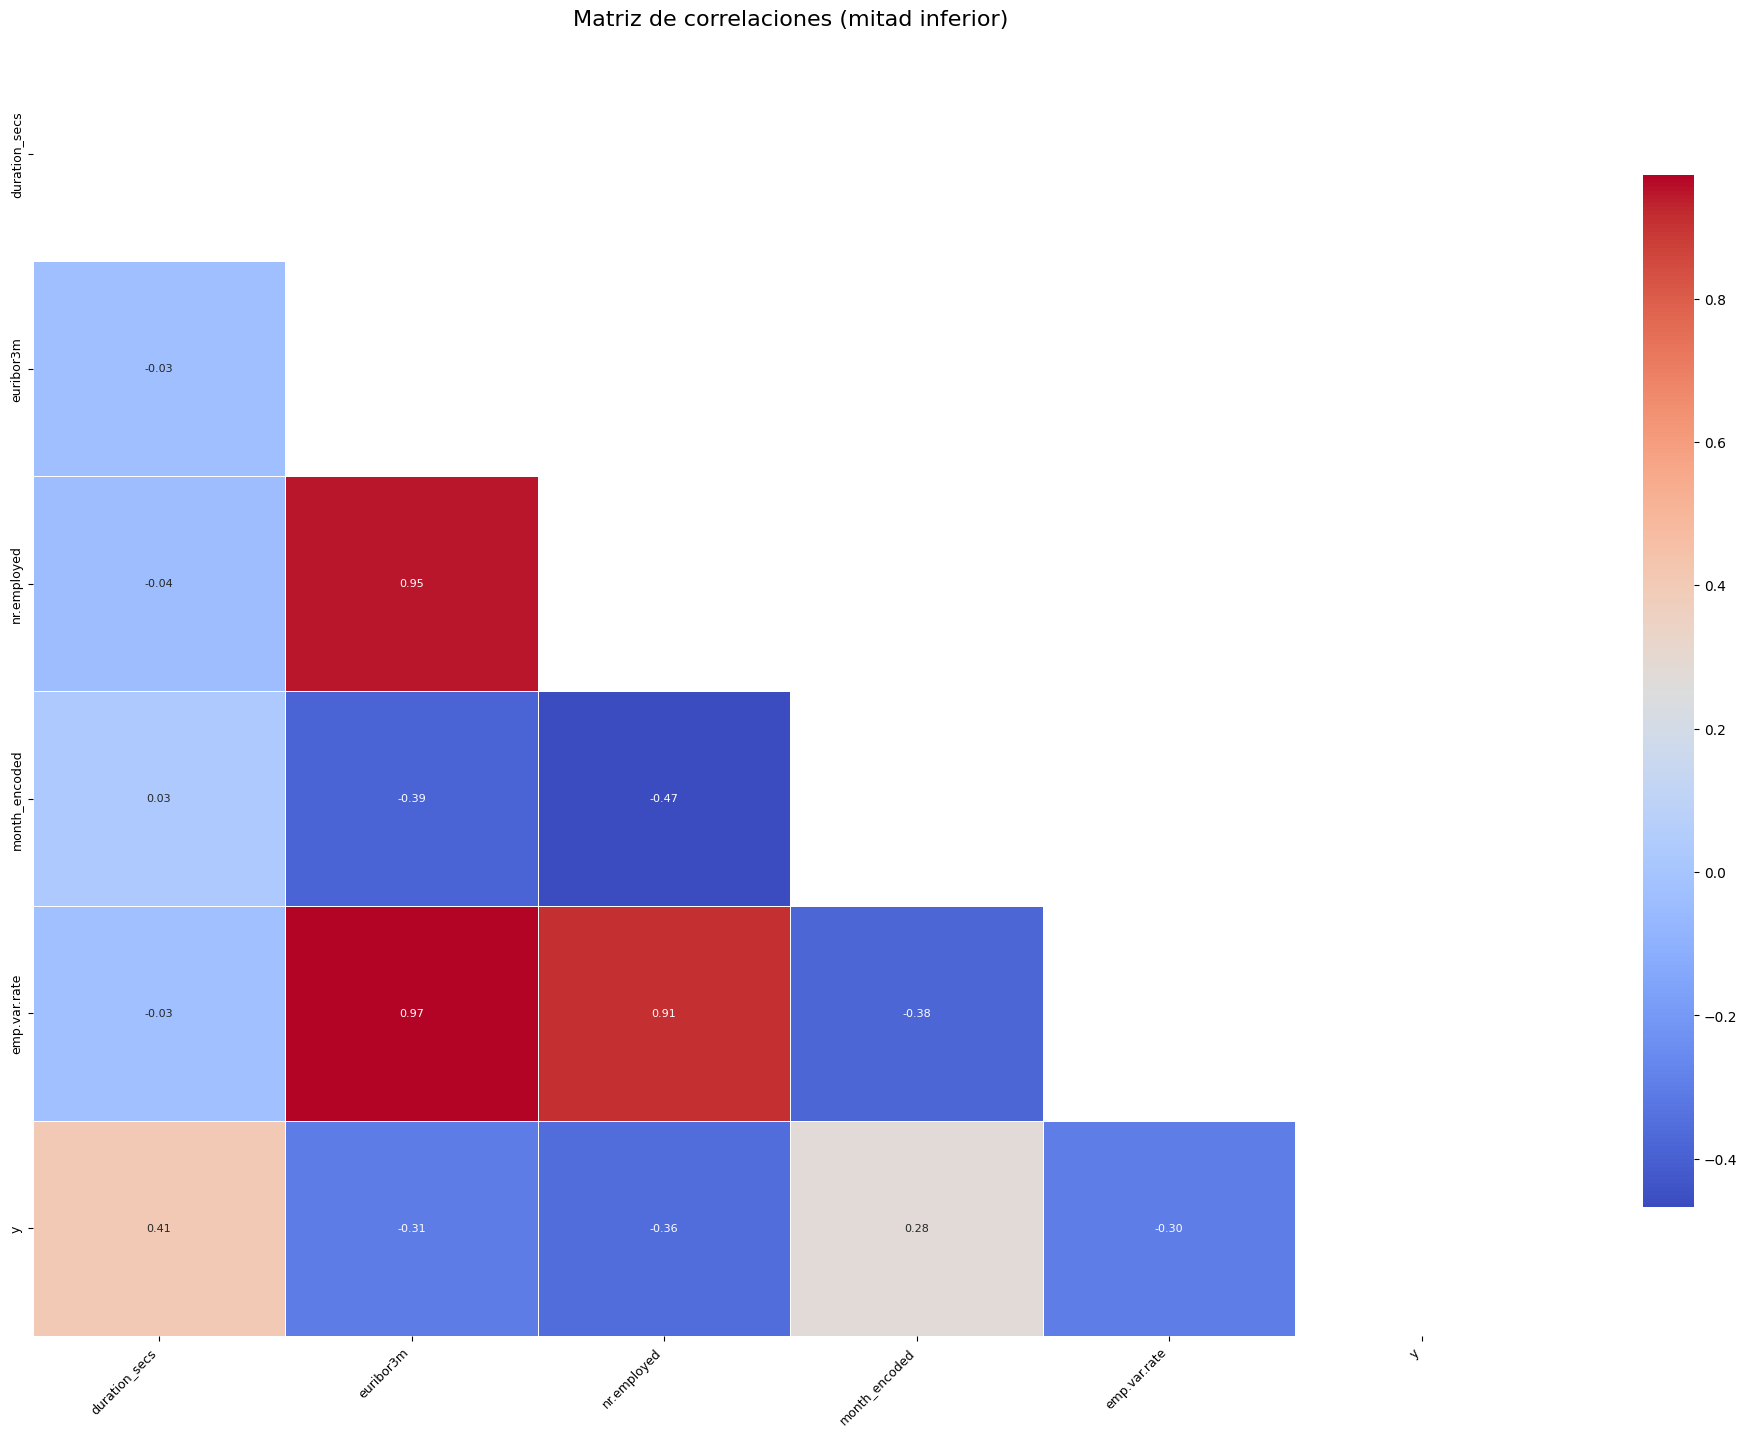

In [50]:
X_copy = X_train[features].copy()
X_copy['y'] = Y_train
corr = X_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()

Cross validation

In [51]:
#V1

cv_Results1 = cross_val_score(RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'),X_train,Y_train,cv=3,scoring='roc_auc')
print(cv_Results1)

[0.94383688 0.94619973 0.93885628]


In [52]:
cv_Results1.mean()

np.float64(0.9429642953310896)

In [53]:
#V2

cv_Results2 = cross_val_score(RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'),X_train[features],Y_train,cv=3,scoring='roc_auc')
print(cv_Results2)


[0.92181844 0.92077692 0.92033013]


In [54]:
cv_Results2.mean()

np.float64(0.9209751644823414)

In [55]:
#V3

cv_Results3 = cross_val_score(RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'),X_train[features].drop(['nr.employed'],axis=1),Y_train,cv=3,scoring='roc_auc')

print(cv_Results3)


[0.92096912 0.92356432 0.92217605]


In [56]:
cv_Results3.mean()

np.float64(0.9222364976550107)

Modelado

In [57]:
#select caract
X_train_sel = X_train[features]
X_test_sel = X_test[features]

In [58]:
X_train_sel.describe()

,duration_secs,euribor3m,nr.employed,month_encoded,emp.var.rate
count,32940.00,32940.00,32940.00,32940.00,32940.00
mean,256.97,3.62,5167.06,0.11,0.08
std,258.11,1.73,72.37,0.09,1.57
min,0.00,0.63,4963.60,0.06,-3.40
25%,102.00,1.34,5099.10,0.06,-1.80
50%,178.00,4.86,5191.00,0.09,1.10
75%,318.25,4.96,5228.10,0.10,1.40
max,4918.00,5.04,5228.10,0.52,1.40


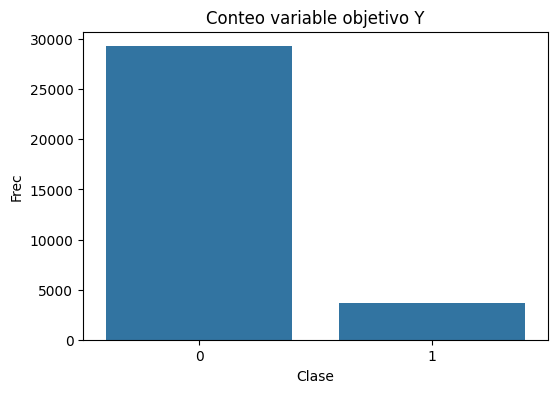

In [59]:
conteo = Y_train.value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=conteo.index,y=conteo.values)
plt.title('Conteo variable objetivo Y')
plt.xlabel('Clase')
plt.ylabel('Frec')
plt.show()

In [60]:
Y_train.skew()
#cola larga a la derecha

np.float64(2.4710795926149975)

Escalado de datos
pregunta: como saber si lo que debo hacer es normalizacion o estandarizacion?

In [61]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train_sel)
X_test_sc = scaler.transform(X_test_sel)

Entrenamiento del modelo

In [93]:
modelv1 = LogisticRegression()
modelv1.fit(X_train_sc,Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Pred. Modelo

In [103]:
y_pred1 = modelv1.predict(X_test_sc)
y_pred1

array([1, 0, 1, ..., 0, 0, 0], shape=(8236,))

In [104]:
base_accuracy1 = accuracy_score(Y_Test,y_pred1)
base_accuracy1

0.8969159786304031

In [105]:
report = classification_report(Y_Test,y_pred1)
print(report)



              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7265
           1       0.62      0.32      0.43       971

    accuracy                           0.90      8236
   macro avg       0.77      0.65      0.68      8236
weighted avg       0.88      0.90      0.88      8236



Model optimization / Hyperparameter tuning

In [111]:
#busqueda extensiva
params = {'penalty':['l1', 'l2', 'elasticnet', None],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': ['balanced',None],
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

model = lgb.LGBMClassifier(random_state=42)

#rndomized search 

random_search = RandomizedSearchCV(estimator=model,param_distributions=params,n_iter=5,verbose=4,n_jobs=-1,random_state=123)

random_search.fit(X_train_sc,Y_train)

print("Mejores hiperparámetros:")
print(random_search.best_params_)

best_model = random_search.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Warning] Unknown parameter: C[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: penalty
[LightGBM] [Warning] Unknown parameter: penalty
[LightGBM] [Warning] Unknown parameter: solver

[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: penalty
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Info] Number of positive: 2935, number of negative: 23417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 26352, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start trai

In [114]:
modelv2 = LogisticRegression(solver='lbfgs',penalty= None, class_weight= None, C= 100)
modelv2.fit(X_train_sc,Y_train)

,penalty,None
,dual,False
,tol,0.0001
,C,100
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [115]:
y_pred2 = modelv2.predict(X_test_sc)
y_pred2

array([1, 0, 1, ..., 0, 0, 0], shape=(8236,))

In [116]:
base_accuracy2= accuracy_score(Y_Test,y_pred2)
base_accuracy2

0.896551724137931

In [117]:
report = classification_report(Y_Test,y_pred2)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7265
           1       0.62      0.32      0.42       971

    accuracy                           0.90      8236
   macro avg       0.77      0.65      0.68      8236
weighted avg       0.88      0.90      0.88      8236



In [92]:
#Busqueda intensiva



param_grid = {'penalty':['l1', 'l2', 'elasticnet', None],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': ['balanced',None],
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

grid_search = GridSearchCV(model,param_grid= param_grid,cv=5)

grid_search.fit(X_train_sc,Y_train)

print("Mejores hiperparámetros:")
print(grid_search.best_params_)

best_model2 = grid_search.best_estimator_

Mejores hiperparámetros:
{'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}


In [118]:
modelv3 = LogisticRegression(penalty='l1',C=0.1,class_weight=None,solver='saga')
modelv3.fit(X_train_sc,Y_train)
y_pred_v2 = modelv3.predict(X_test_sc)

grid_accuracy = accuracy_score(Y_Test,y_pred_v2)
grid_accuracy



0.8972802331228752

In [89]:
report = classification_report(Y_Test,y_pred_v2)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7265
           1       0.42      0.84      0.56       971

    accuracy                           0.85      8236
   macro avg       0.70      0.84      0.74      8236
weighted avg       0.91      0.85      0.87      8236



Exportacion del modelo

In [119]:
joblib.dump(best_model, 'modelo_depositos.pkl')


['modelo_depositos.pkl']

In [120]:
#cargar modelo

modelo_final = joblib.load('modelo_depositos.pkl')